In [1]:
# a.1) setup path to data-containing folder and savings and parameters
h5ad_path = "/Users/AlexanderWang/Desktop/ics-rebuttal/TE006-h5ad/"
figures_dir = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/"
figures_dir_RNAVeloKernel = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/"
figures_dir_TE006 = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/"
name_prefix = "TE006_"

n_macro_CytoTRACE = 8 # number of macrostates 
scale_data = True

In [2]:
# a.2) packages
import anndata
import sys
import cellrank as cr
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
from scipy.stats import rankdata
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 

scp -P 59922 aw3436@login.c2b2.columbia.edu:/ifs/scratch/c2b2/ac_lab/lz2841/ics-rebuttal/TE006/TE006-cells-original-data.h5ad /Users/AlexanderWang/Desktop/ics-rebuttal/TE006-h5ad/

scp -P 59922 aw3436@login.c2b2.columbia.edu:/ifs/scratch/c2b2/ac_lab/lz2841/ics-rebuttal/TE001-h5ad/TE001-counts.h5ad /Users/AlexanderWang/Desktop/ics-rebuttal/TE001-h5ad/

In [3]:
# a.3) load counts data 
adata = anndata.read_loom(h5ad_path + "TE006.loom")
cell_ids = adata.obs.index.values.copy()
cell_ids = np.array([item.replace('TE006_', '') for item in cell_ids])
cell_ids = np.array([item + '-1' for item in cell_ids])
adata.obs.index = cell_ids
adata.obs['cell_id'] = adata.obs.index

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
# a.4) load metadata for TE001 
pax_data = sc.read_h5ad(h5ad_path + "TE006-viper.h5ad")
specified_columns = ["cell_id", "cytotrace_score_ges",
                     "seurat_clusters", "singleR_labels",
                    'UMAP_1.PAS','UMAP_2.PAS']

pax_data.obs = pax_data.obs[specified_columns]

# a.5) process metadata in adata
cells_to_analyze = pax_data.obs['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata
adata.obs = pd.merge(adata.obs, pax_data.obs, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object


In [5]:
metadata_csv = h5ad_path + "ablation-metadata-ingest.csv"
metadata = pd.read_csv(metadata_csv)


cells_to_analyze = metadata['cell_id'] # cells to analyze
# metadata = metadata.rename(columns={"index": "cell_id"})
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype('category') # VIPER clusters as categorical variable

# a.7) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan


# a.6) set UMAP coordinates to those obtained at protein activty
# umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1.PAS.with_seurat','UMAP_2.PAS.with_seurat']]) # Strange results
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1','UMAP_2']]) 
adata.obsm['X_umap'] = umap_coordinates

In [6]:
# np.count_nonzero(np.isin(pax_data.obs_names.values, adata.obs_names.values))

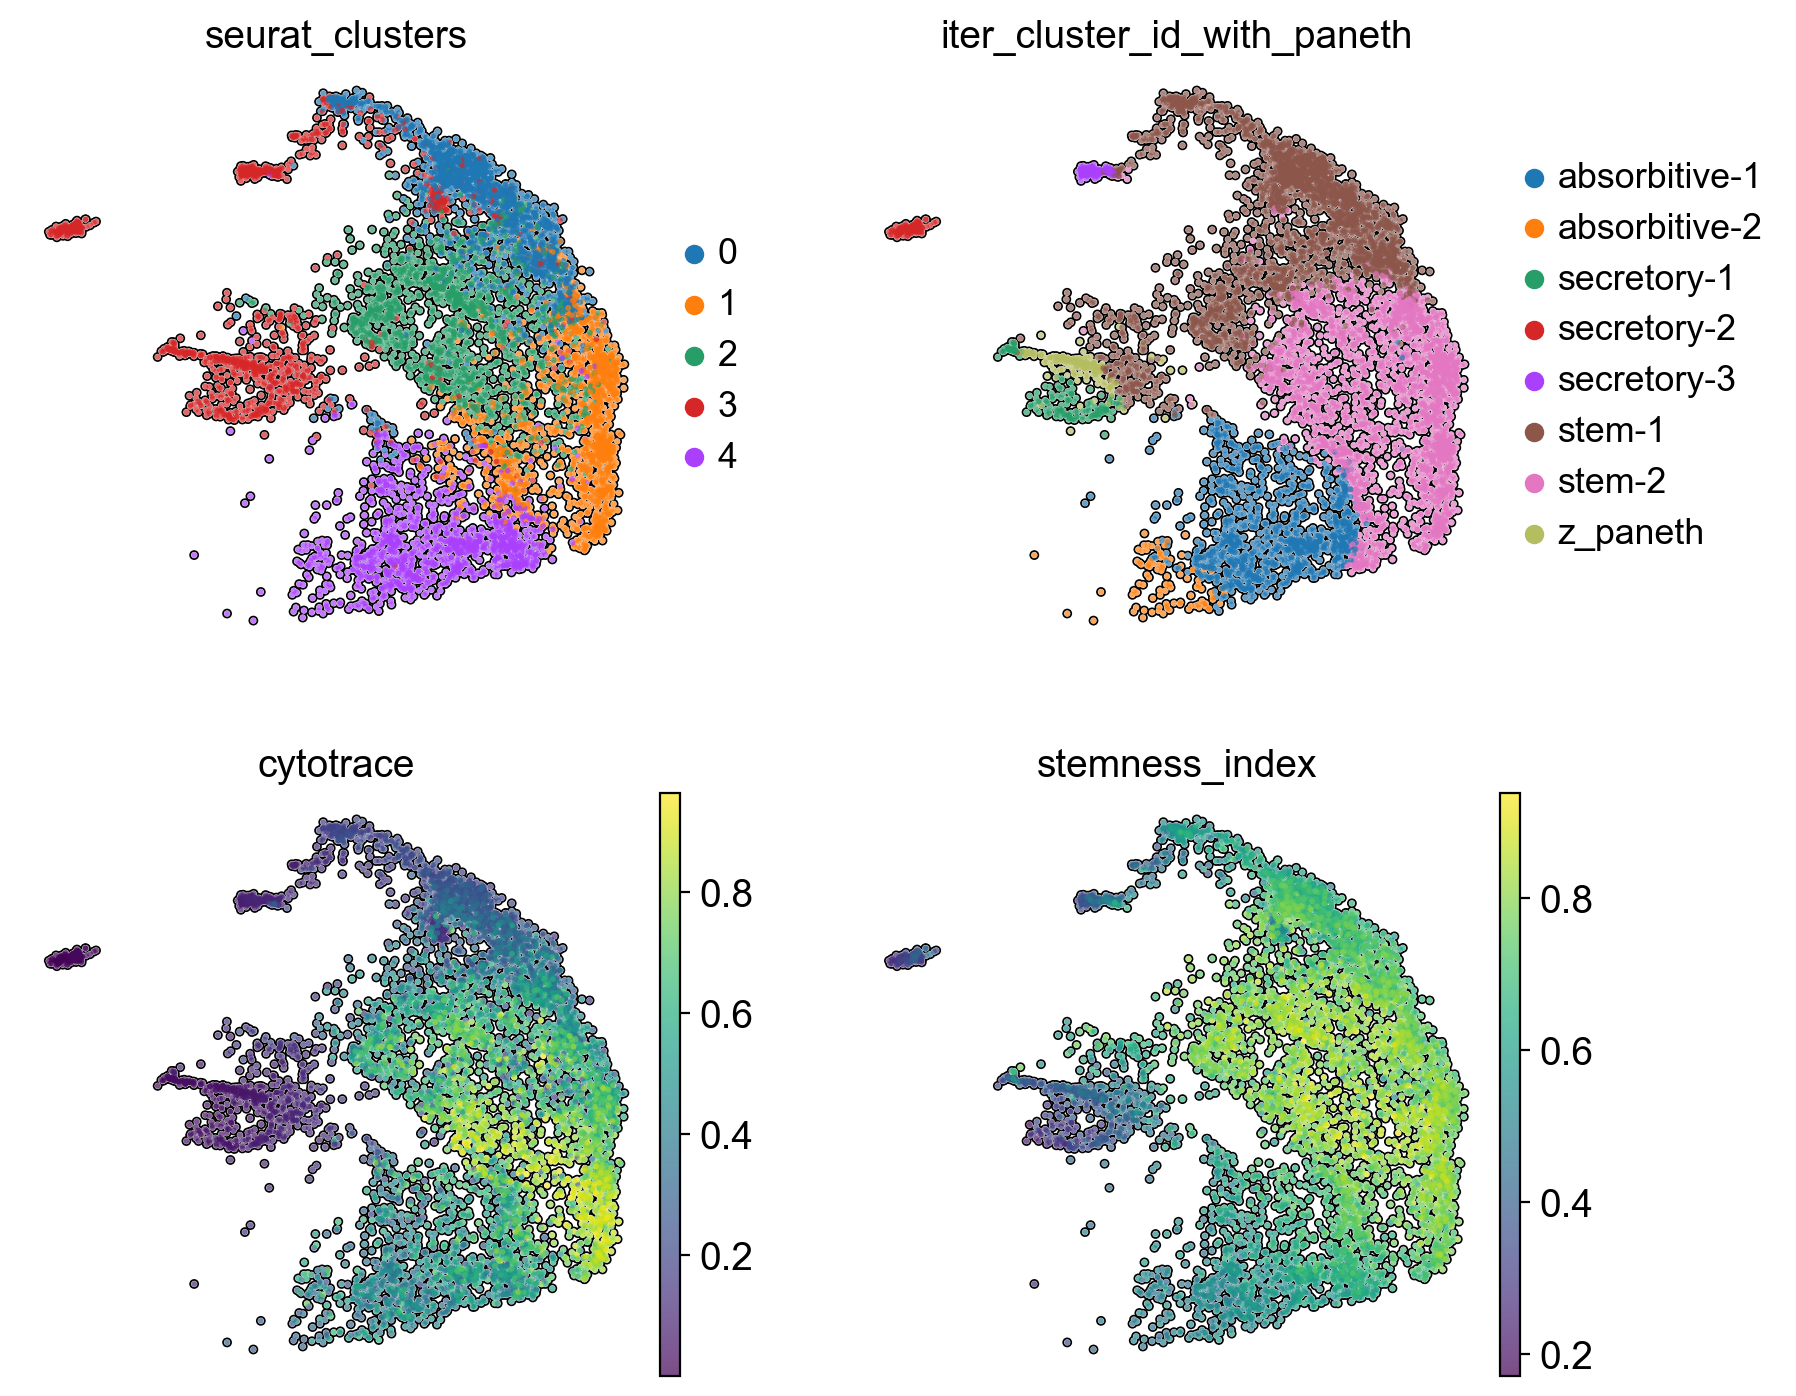

In [7]:
sc.pl.umap(adata, color=["seurat_clusters",'iter_cluster_id_with_paneth',"cytotrace","stemness_index"], ncols=2, add_outline=True)

In [8]:
### b) Preprocess the data 
print("Preprocessing counts matrix for CellRank 2 analysis")

Preprocessing counts matrix for CellRank 2 analysis


In [9]:
import scvelo as scv

In [10]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

Filtered out 46401 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/Users/AlexanderWang/opt/miniconda3/envs/cellrank_env_py3_10_osx_arm64/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [11]:
if scale_data:
    adata_scale = anndata.AnnData(adata.X.copy())
    sc.pp.scale(adata_scale)
    adata_scale.to_df()
    sc.tl.pca(adata_scale)
    adata.obsm['X_pca'] = adata_scale.obsm['X_pca'].copy()
    del adata_scale
else:
    sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(adata, n_jobs=4)

recovering dynamics (using 4/8 cores)


  0%|          | 0/1557 [00:00<?, ?gene/s]

    finished (0:04:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [13]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
vk = cr.kernels.VelocityKernel(adata)

In [15]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/6977 [00:00<?, ?cell/s]

Using `softmax_scale=12.6446`


  0%|          | 0/6977 [00:00<?, ?cell/s]

    Finish (0:00:22)


VelocityKernel[n=6977, model='deterministic', similarity='correlation', softmax_scale=12.645]

In [16]:
# c.2) Set up figure directories
if os.path.exists(figures_dir):
    print("'figures_dir' directory already exists")
else:
    os.mkdir(figures_dir)

if os.path.exists(figures_dir_RNAVeloKernel):
    print("'figures_dir_VIPERKernel' directory already exists")
else:
    os.mkdir(figures_dir_RNAVeloKernel)

if os.path.exists(figures_dir_TE006):
    print("'figures_dir_TE001' directory already exists")
else:
    os.mkdir(figures_dir_TE006)

'figures_dir' directory already exists
'figures_dir_VIPERKernel' directory already exists


Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_VIPERKernel_differentiation_seurat_clusters.svg


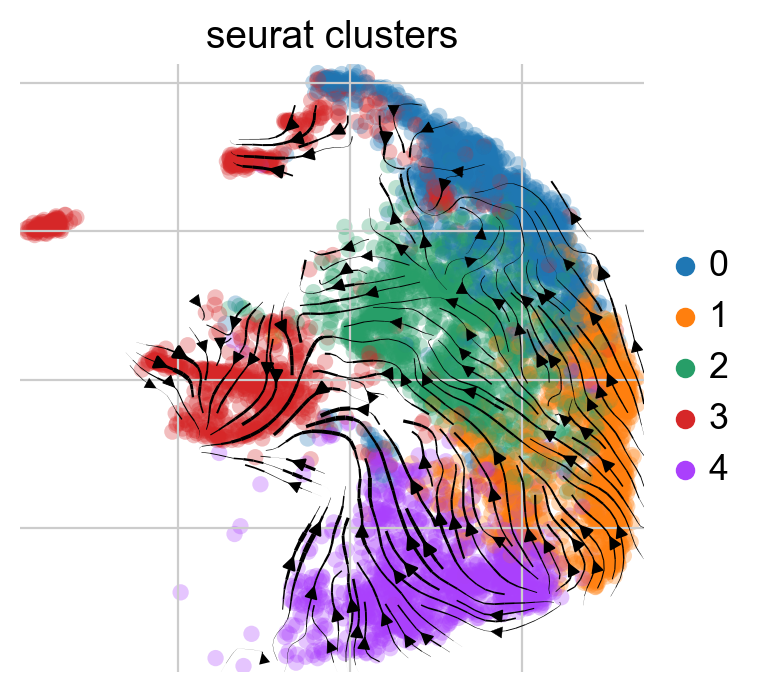

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_VIPERKernel_differentiation_pa_clusters.svg


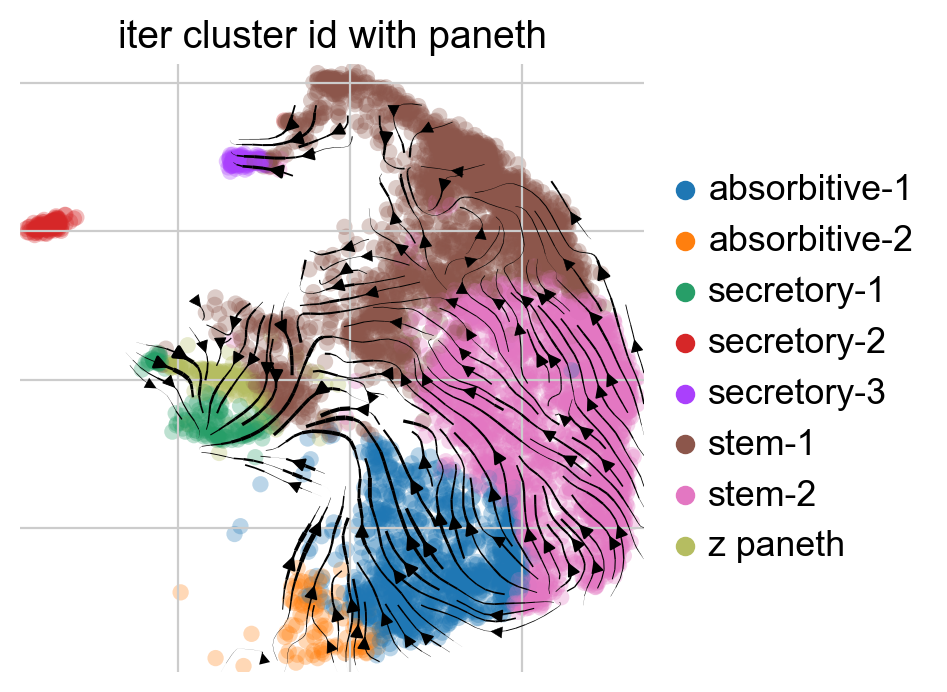

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_VIPERKernel_differentiation_cytotrace.svg


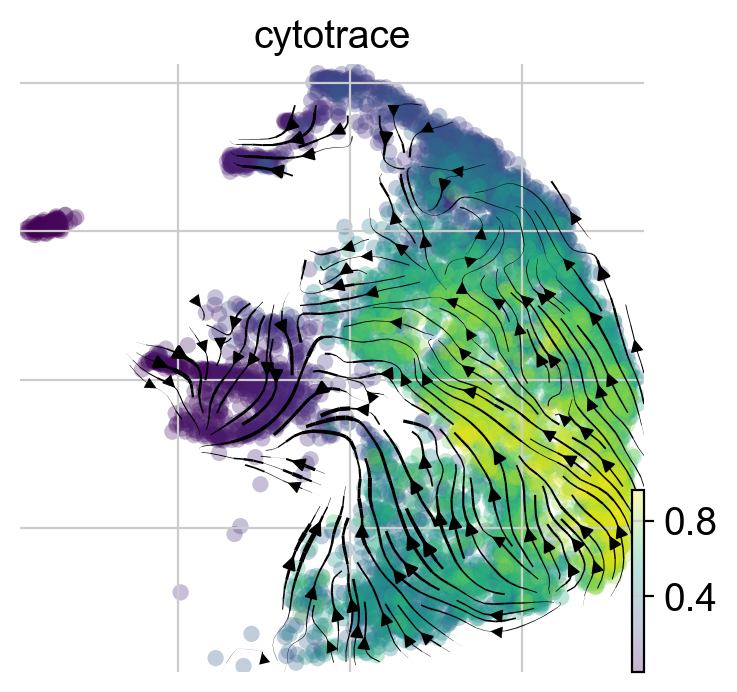

In [17]:
vk.adata.obs['seurat_clusters'] = vk.adata.obs['seurat_clusters'].astype('category') # clusters as categorical variable
# c.6) visualize the transition matrix
differentiation_figure = figures_dir_TE006 + name_prefix + "VIPERKernel_differentiation_seurat_clusters.svg"
vk.plot_projection(basis="umap",
                   color="seurat_clusters", 
                   legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE006 + name_prefix + "VIPERKernel_differentiation_pa_clusters.svg"
vk.plot_projection(basis="umap",
                   color = "iter_cluster_id_with_paneth", 
                   legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE006 + name_prefix + "VIPERKernel_differentiation_cytotrace.svg"
vk.plot_projection(basis="umap",
                   color="cytotrace", 
                   legend_loc="right", save=differentiation_figure, show=True)


In [18]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


ConnectivityKernel[n=6977, dnorm=True, key='connectivities']

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_ConnectivityKernel_differentiation_ges_clusters.svg


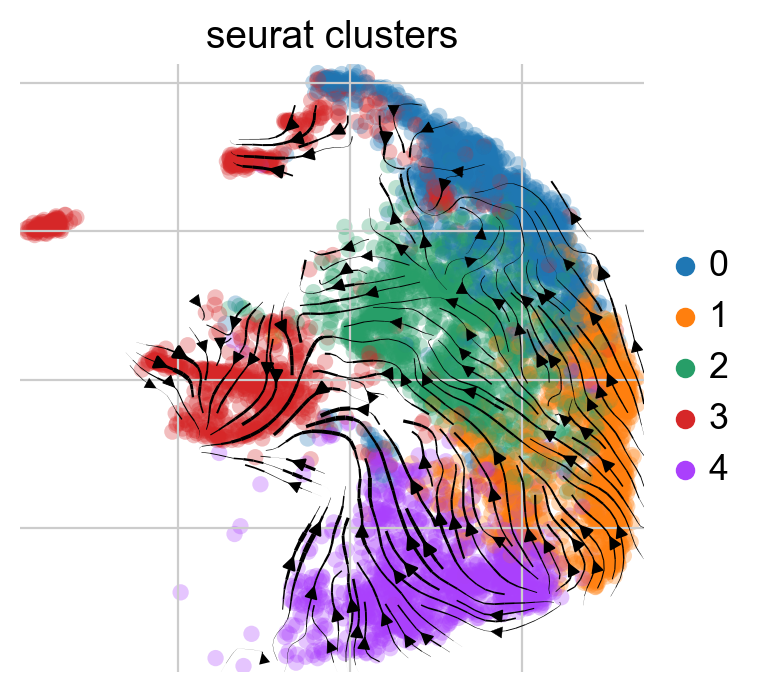

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_ConnectivityKernel_differentiation_pa_clusters.svg


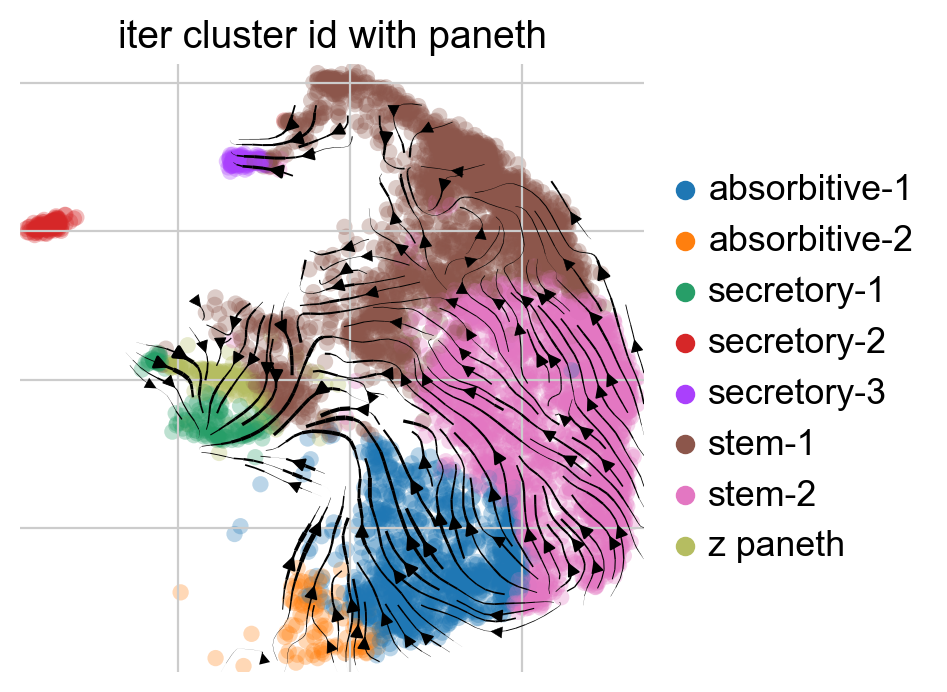

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_ConnectivityKernel_differentiation_cytotrace.svg


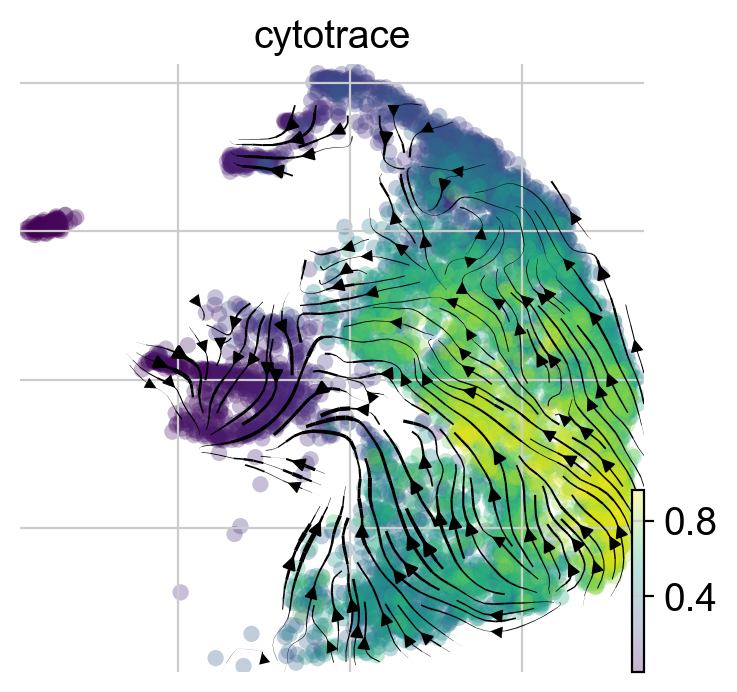

In [19]:
differentiation_figure = figures_dir_TE006 + name_prefix + "ConnectivityKernel_differentiation_ges_clusters.svg"
ck.plot_projection(basis="umap",
                   color="seurat_clusters", 
                   legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE006 + name_prefix + "ConnectivityKernel_differentiation_pa_clusters.svg"
ck.plot_projection(basis="umap",
                   color = "iter_cluster_id_with_paneth", 
                   legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE006 + name_prefix + "ConnectivityKernel_differentiation_cytotrace.svg"
ck.plot_projection(basis="umap",
                   color="cytotrace", 
                   legend_loc="right", save=differentiation_figure, show=True)

In [20]:
combined_kernel = 0.8 * vk + 0.2 * ck

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_CombinedKernel_differentiation_ges_clusters.svg


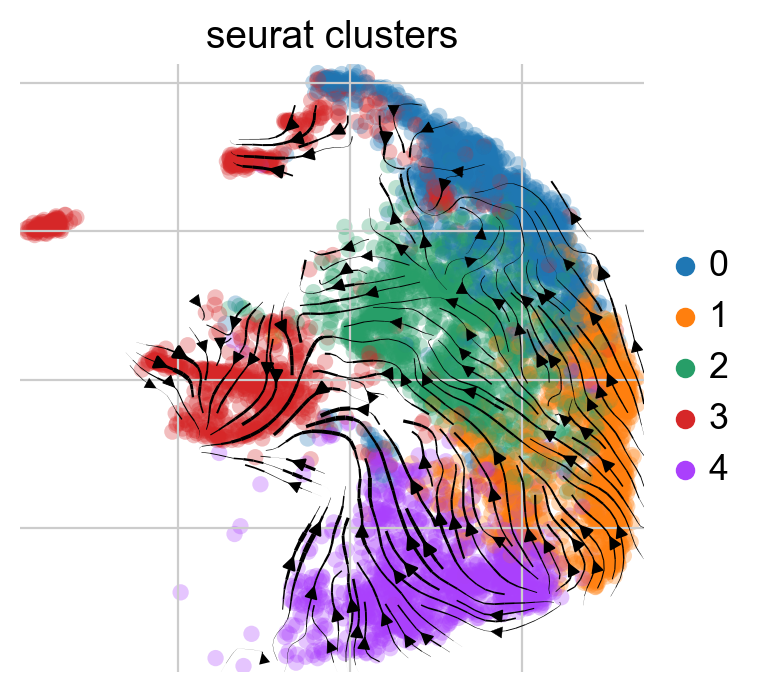

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_CombinedKernel_differentiation_pa_clusters.svg


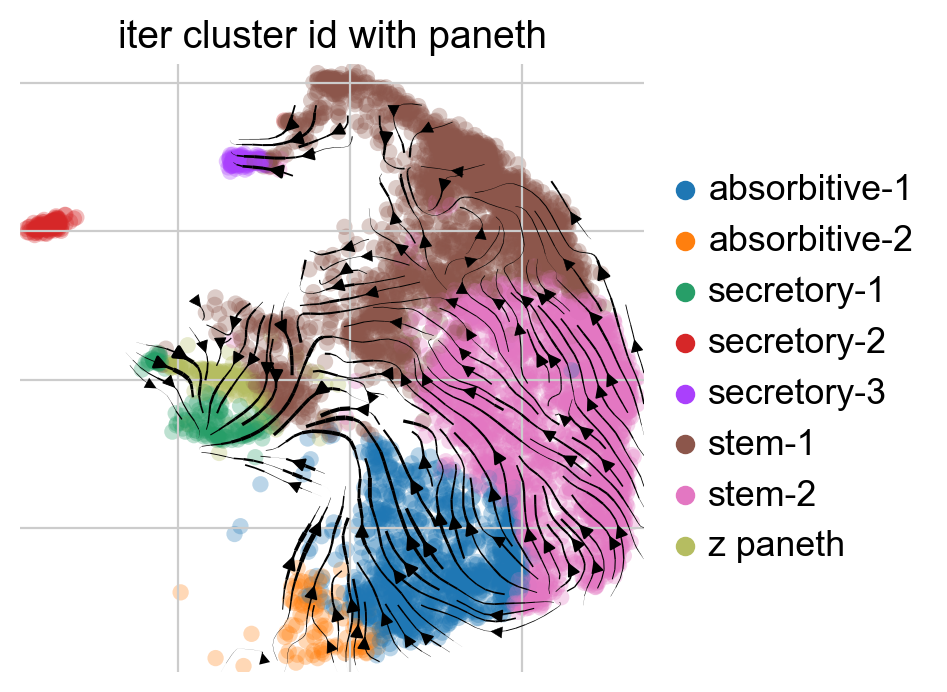

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_CombinedKernel_differentiation_cytotrace.svg


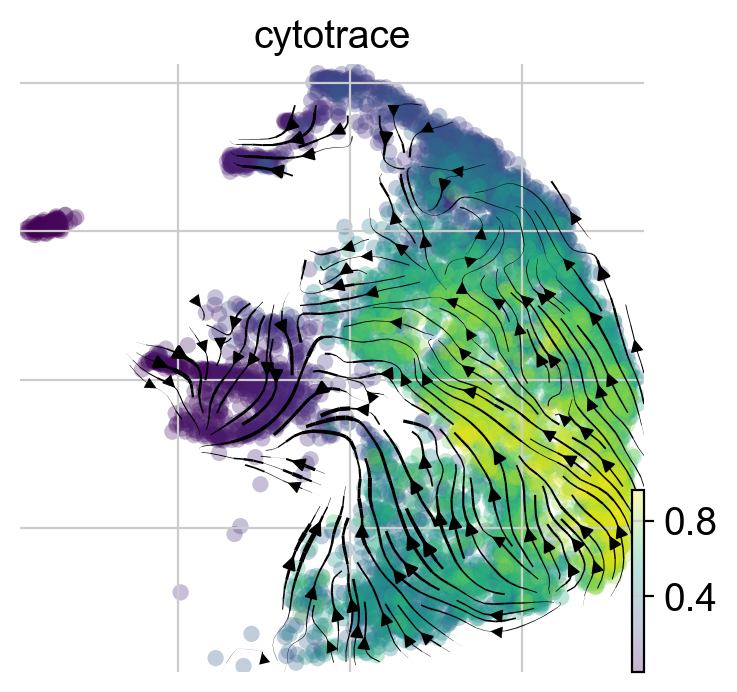

In [21]:
differentiation_figure = figures_dir_TE006 + name_prefix + "CombinedKernel_differentiation_ges_clusters.svg"
combined_kernel.plot_projection(basis="umap",
                                color="seurat_clusters",
                                legend_loc="right", save=differentiation_figure, show=True)


differentiation_figure = figures_dir_TE006 + name_prefix + "CombinedKernel_differentiation_pa_clusters.svg"
combined_kernel.plot_projection(basis="umap",
                                color = "iter_cluster_id_with_paneth", 
                                legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE006 + name_prefix + "CombinedKernel_differentiation_cytotrace.svg"
combined_kernel.plot_projection(basis="umap",
                                color="cytotrace", 
                                legend_loc="right", save=differentiation_figure, show=True)

In [22]:
from cellrank.estimators import GPCCA
# d.1) compute estimator
g_vk = cr.estimators.GPCCA(vk)
g_vk.compute_schur(n_components=21) # compute Schur decomposition

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[11, 13, 15, 17, 19, 21]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:03:21)


GPCCA[kernel=VelocityKernel[n=6977], initial_states=None, terminal_states=None]

/Users/AlexanderWang/opt/miniconda3/envs/cellrank_env_py3_10_osx_arm64/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


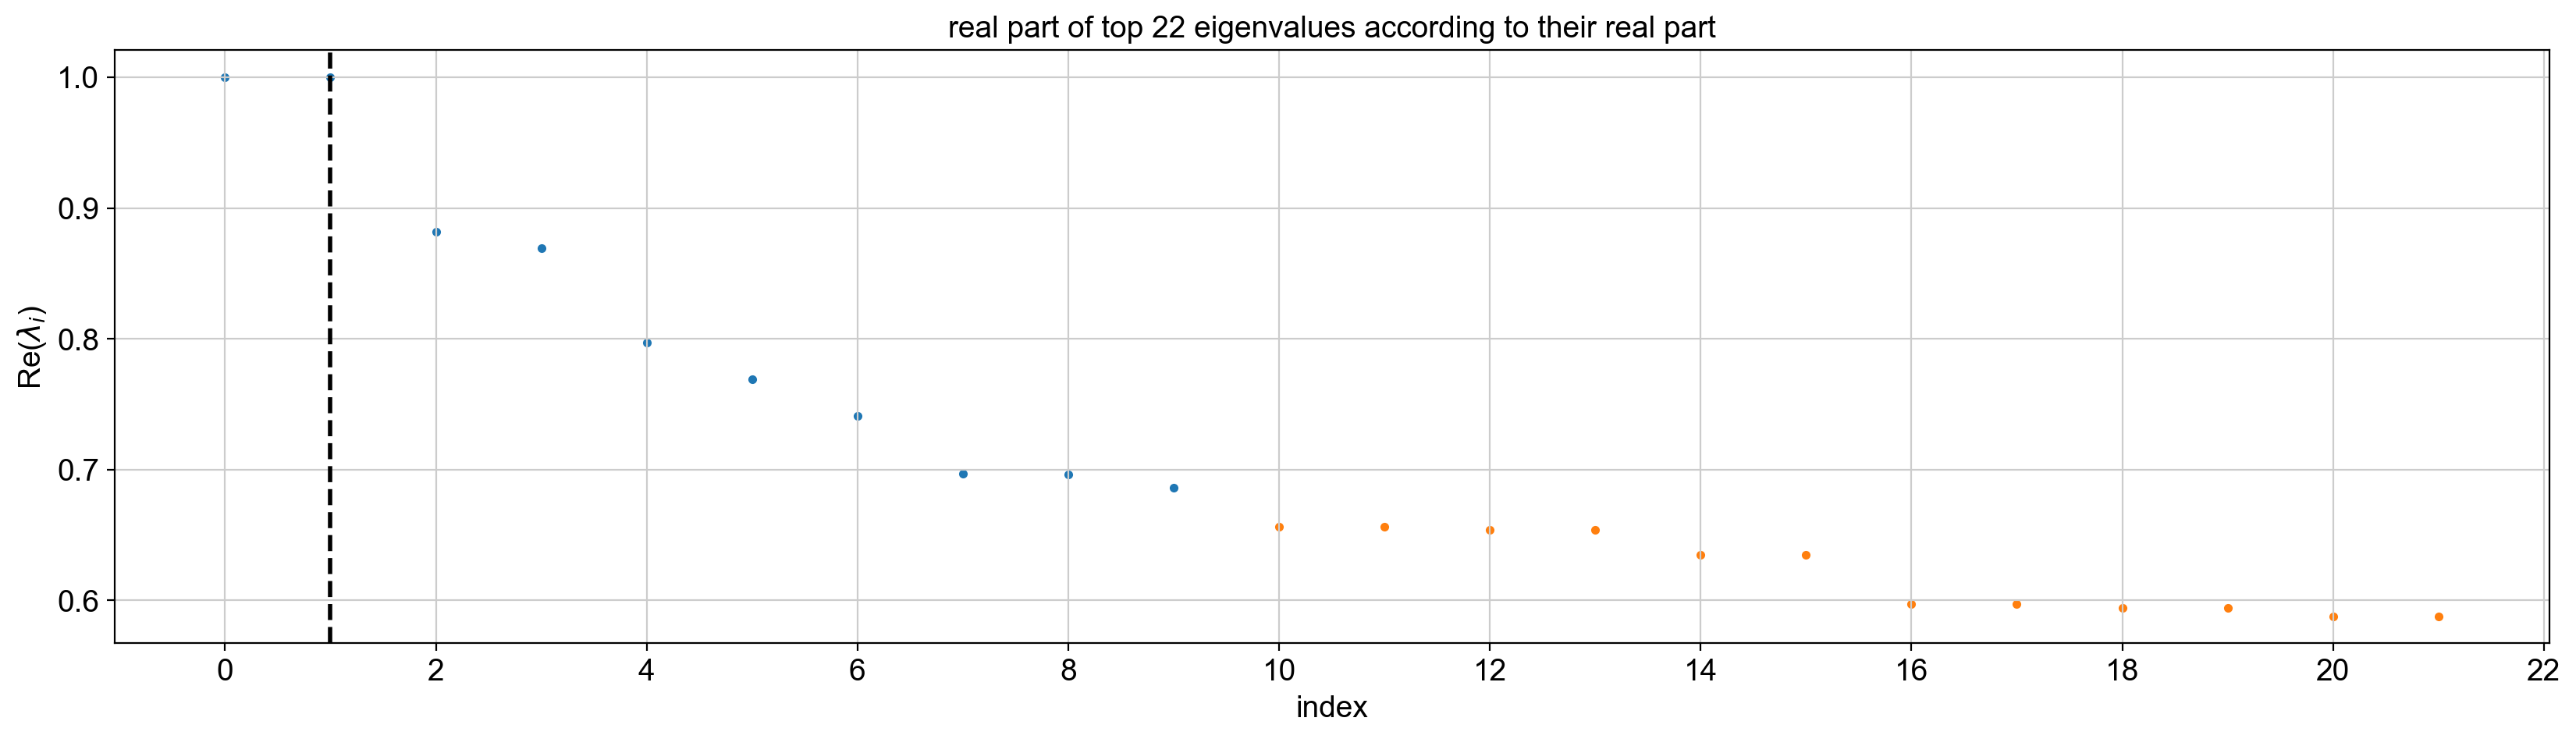

In [23]:
eig_figure = figures_dir_TE006 + name_prefix + "GPCCA_eig.pdf"
g_vk.plot_spectrum(real_only=True, n=None, show_all_xticks=False, save=eig_figure, figsize=(20,5))

Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_GPCCA_macrostates.pdf


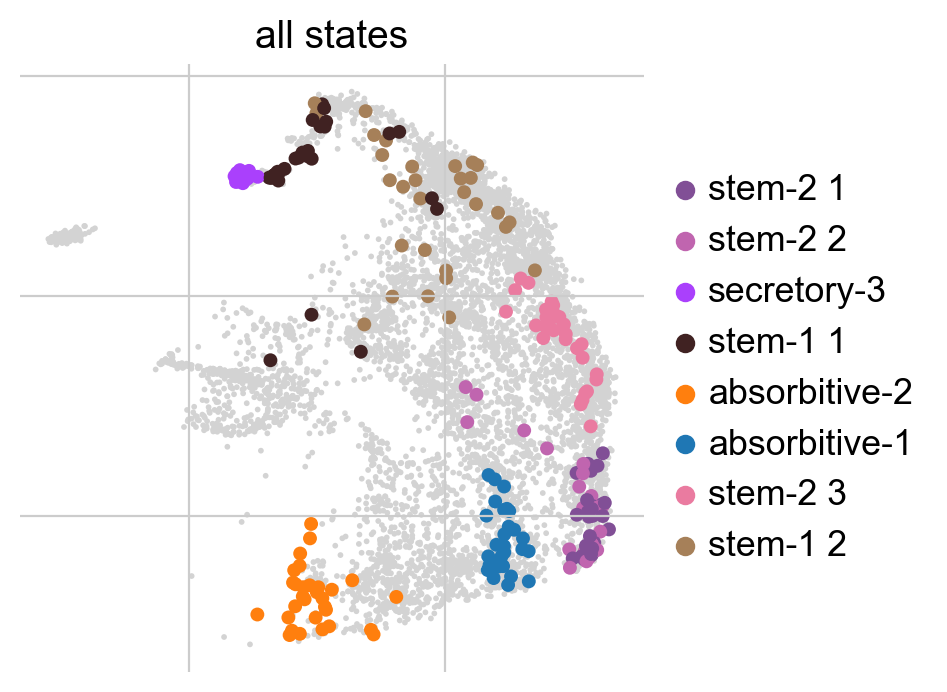

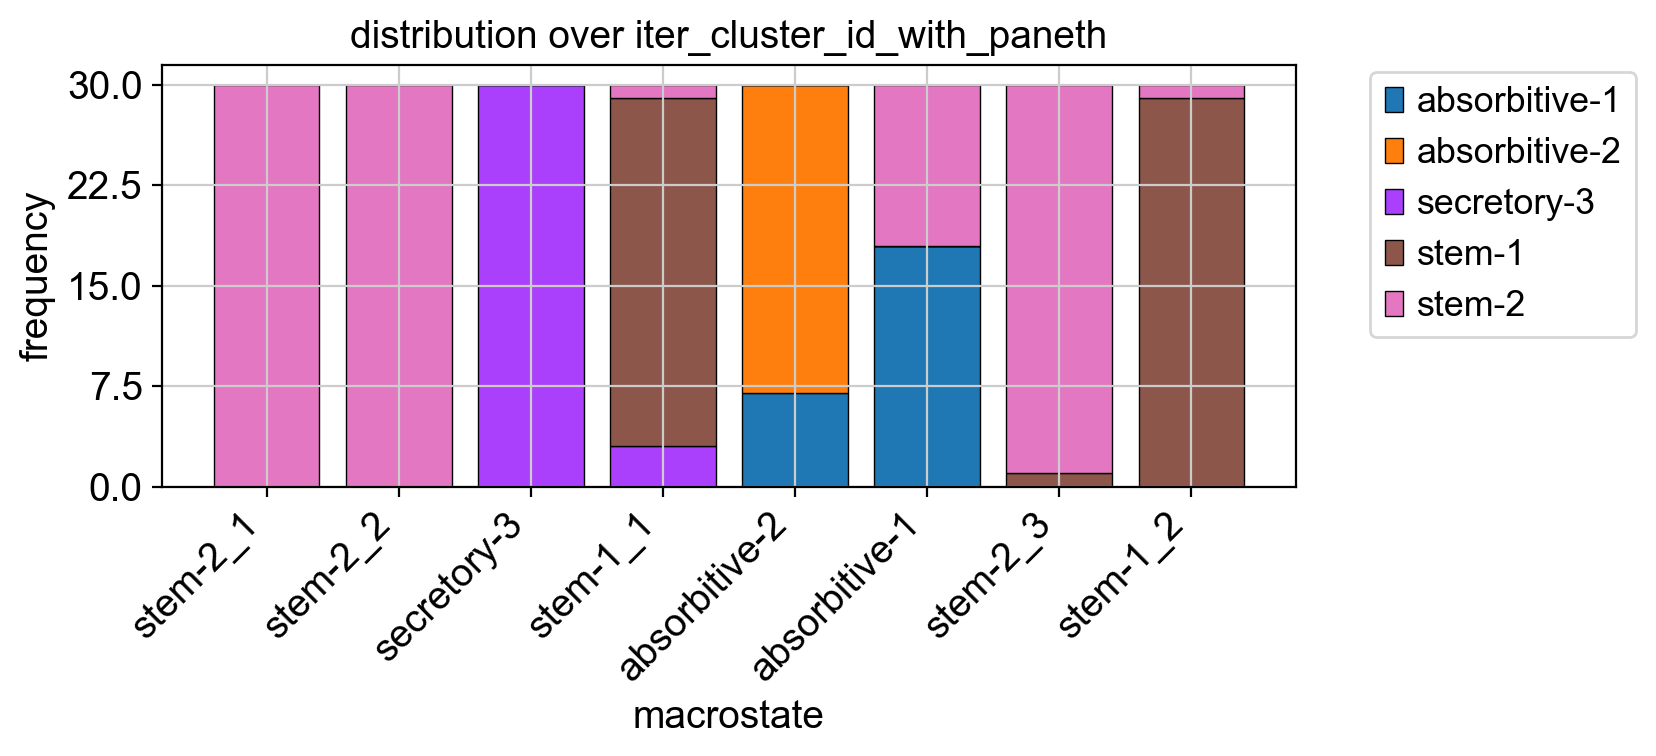

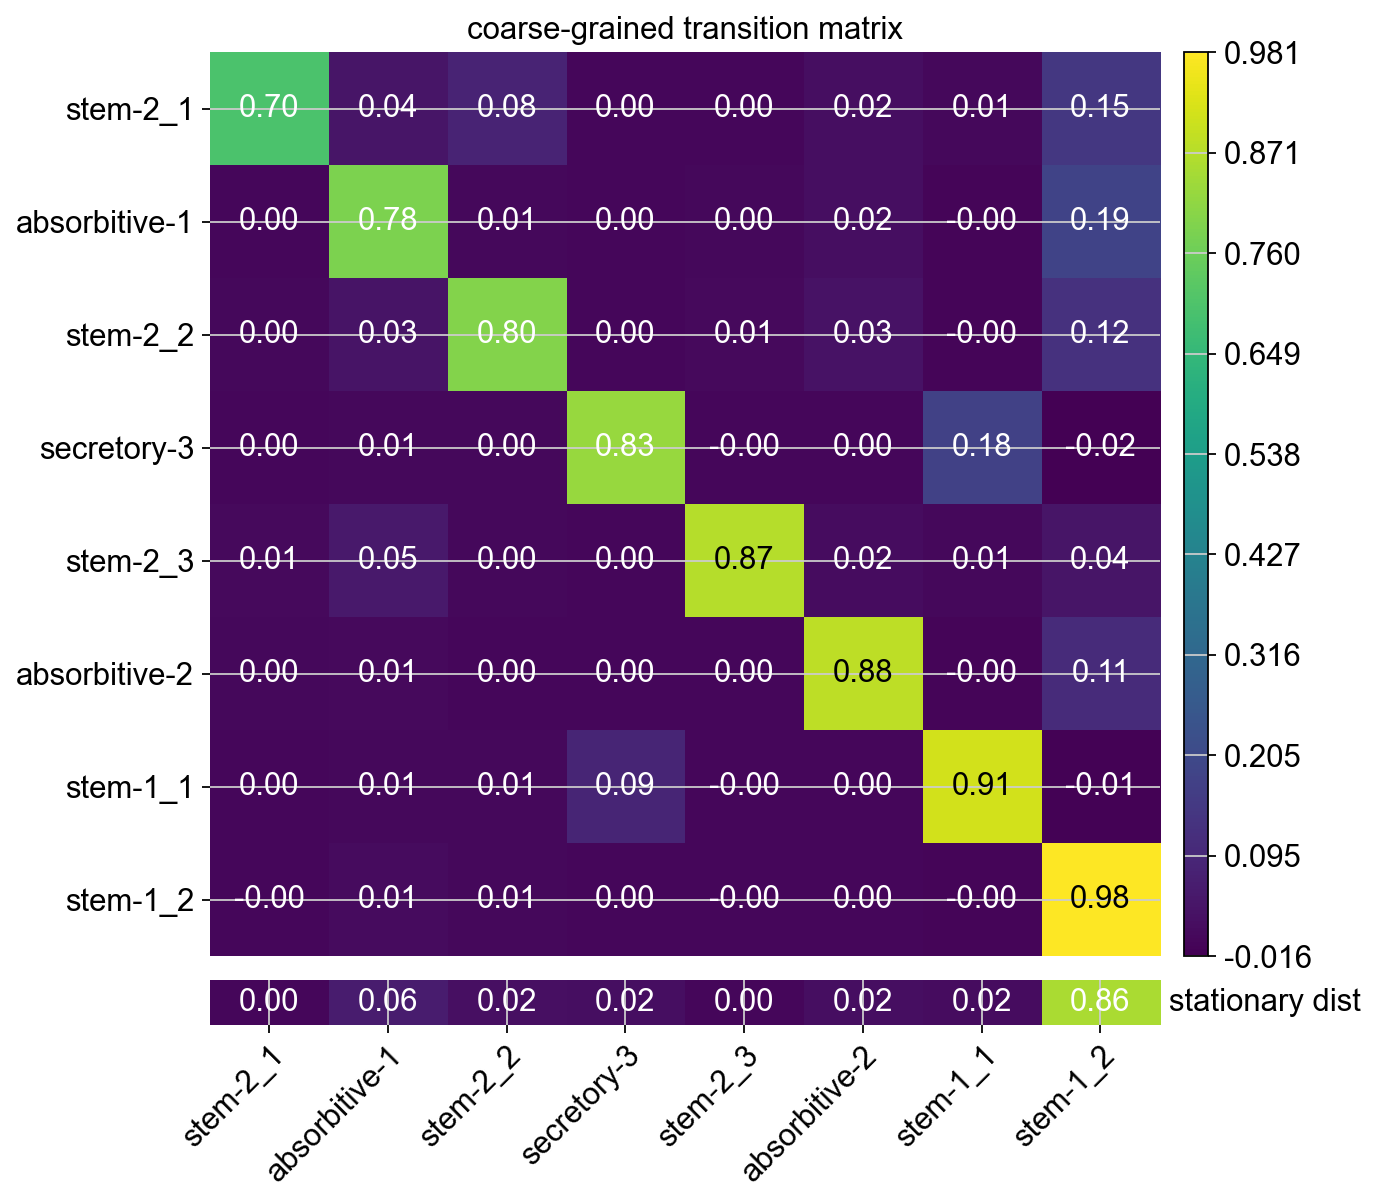

In [24]:
g_vk.compute_macrostates(n_states=8, cluster_key="iter_cluster_id_with_paneth")
macrostates_figure = figures_dir_TE006 + name_prefix + "GPCCA_macrostates.pdf"
g_vk.plot_macrostates(which="all", legend_loc="right", s=100, save=macrostates_figure, show=True)

macrostates_figure_composition = figures_dir_TE006 + name_prefix + "GPCCA_macrostates_composition.pdf"
g_vk.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=True, save=macrostates_figure_composition) # composition of each macrostate

coarse_T_figure = figures_dir_TE006 + name_prefix + "GPCCA_coarse_T.pdf"
g_vk.plot_coarse_T(annotate=True, save=coarse_T_figure) # plot transition matrix

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_GPCCA_initial_states.pdf


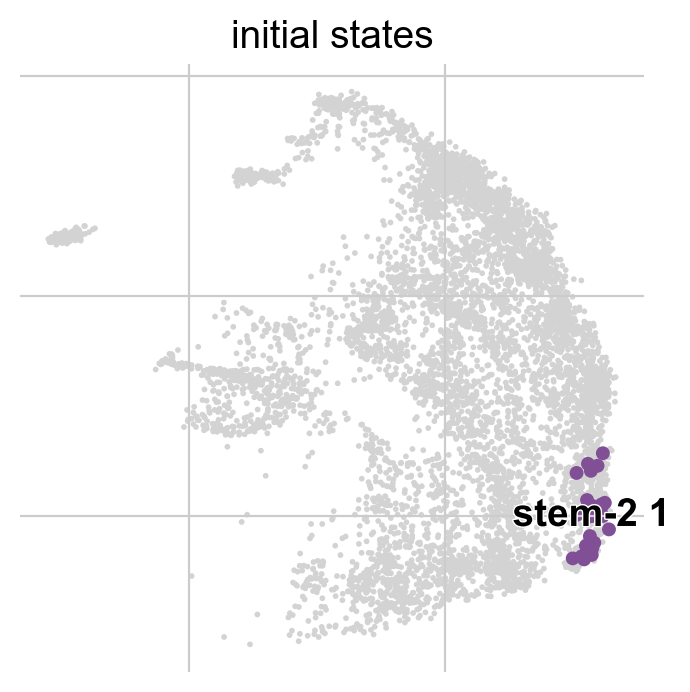

In [25]:
# d.3) predict initial states
g_vk.predict_initial_states(allow_overlap=True)
initial_states_figure = figures_dir_TE006 + name_prefix + "GPCCA_initial_states.pdf"
g_vk.plot_macrostates(which="initial", s=100, save =initial_states_figure, show = True)

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_RNAVeloKernel/TE006/TE006_GPCCA_terminal_states.pdf


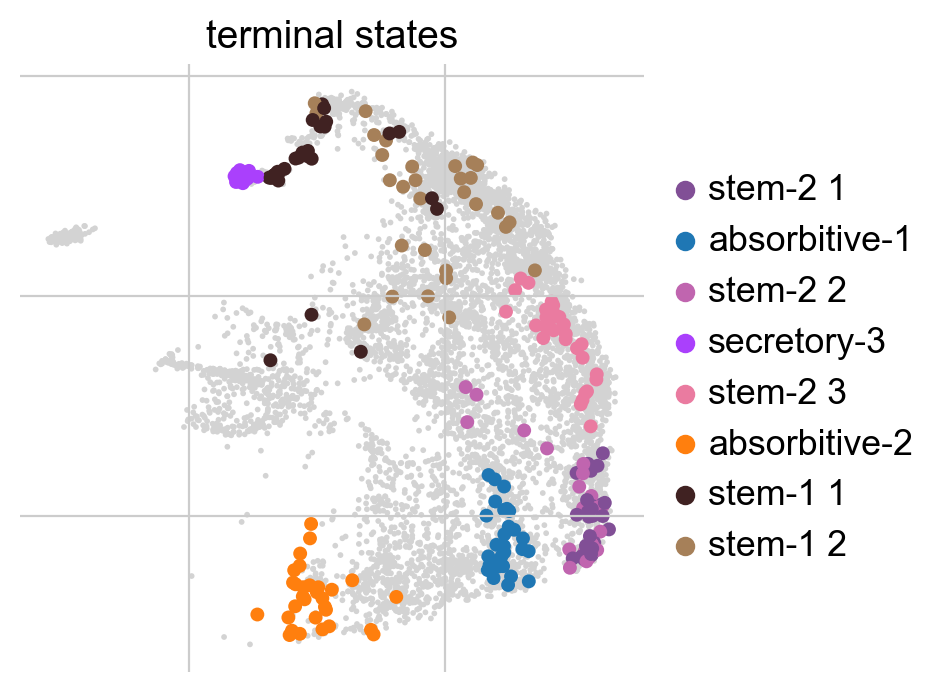

In [26]:
# d.2) compute terminal states
g_vk.predict_terminal_states(method = 'eigengap_coarse',allow_overlap = True)
# g_vk.predict_terminal_states()
terminal_states_figure = figures_dir_TE006 + name_prefix + "GPCCA_terminal_states.pdf"
g_vk.plot_macrostates(which="terminal", legend_loc="right", s=100, save=terminal_states_figure, show=True)